# CNNs en Google Street View
En esta sección se trabajará con un dataset conocido como SVHN (**Street View House Numbers**), el cual contiene imágenes naturales de dígitos de direcciones obtenidos desde la aplicación de Google, *Street View*. El dataset contiene más de 600 mil imágenes de entrenamiento y 26.032 imágenes de test, aunque en esta tarea se trabajará con una pequeña muestra como conjunto de entrenamiento debido a lo costoso computacionalmente del trabajar con las 600 mil imágenes, trabajando con 73.257 imágenes de entrenamiento y 531.131 extras.

 http://ufldl.stanford.edu/housenumbers

In [28]:
import os    
os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32,cuda.root=/usr/local/cuda-7.5/,optimizer=fast_compile" 

import theano
import keras
print theano.config

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils
from keras.utils import plot_model
from IPython.display import Image, display, SVG

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float32

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

device (cpu, gpu*, opencl*, cuda*) 
    Doc:  Default device for computations. If cuda* or opencl*, change thedefault to try to move computation to the GPU. Do not use upper caseletters, only lower case even if NVIDIA uses capital letters.
    Value:  gpu

init_gpu_device (, gpu*, opencl*, cuda*) 
    Doc:  Initialize 

## A) Cargar Dataset

In [29]:
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1 #cambia de 1,2,...,10
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
print np.unique(y_train)

print 'Training set shape: ',X_train.shape
print 'Test set shape: ',X_test.shape 

[0 1 2 3 4 5 6 7 8 9]
Training set shape:  (73257, 3, 32, 32)
Test set shape:  (26032, 3, 32, 32)


In [30]:
#adding Xval
index = np.arange(np.shape(X_train)[0]) #filas 
np.random.shuffle(index) #permutan las filas
X = X_train[index, :] #matriz permutada
Y = y_train[index]
l=13257
X_val,X_train = np.split(X,[l])
y_val,y_train = np.split(Y,[l])
print 'Training set shape: ',X_train.shape
print 'Validation set shape: ',X_val.shape
print 'Test set shape: ',X_test.shape 

Training set shape:  (60000, 3, 32, 32)
Validation set shape:  (13257, 3, 32, 32)
Test set shape:  (26032, 3, 32, 32)


In [31]:
#dar vuelta los canales RGB
X_train = X_train.transpose([0, 2, 3, 1])
X_val = X_val.transpose([0, 2, 3, 1])
X_test = X_test.transpose([0, 2, 3, 1])

### Visualizar imagenes

Para Training set


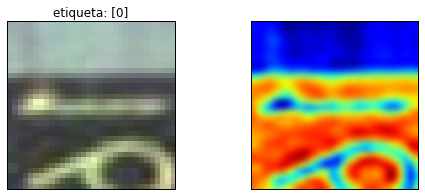

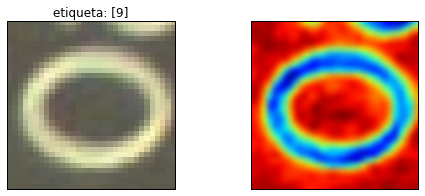

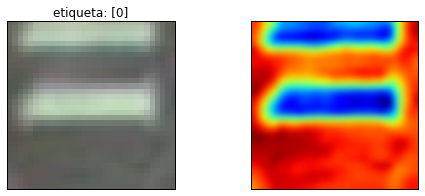

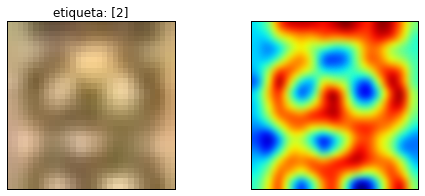

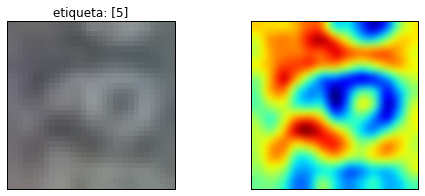

Para Test set


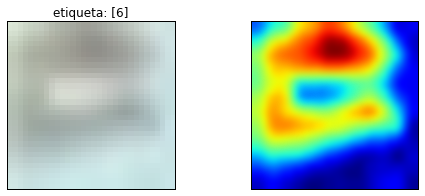

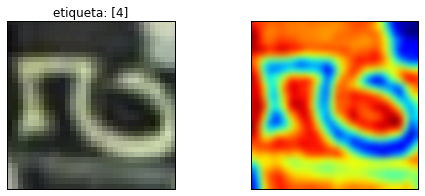

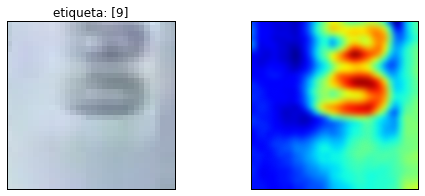

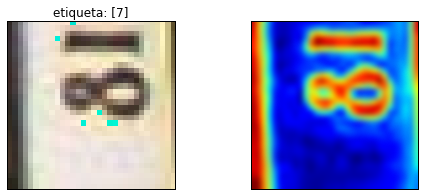

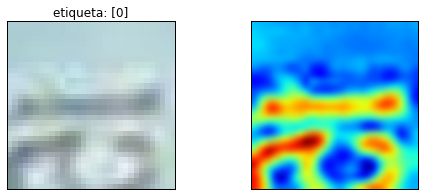

In [42]:
def ver_imagen(X,Y,n):
    canal_r = X[n][:,:,0].copy()
    canal_g = X[n][:,:,1].copy()
    canal_b = X[n][:,:,2].copy()
    
    f,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].set_title("etiqueta: "+str(Y[n]))

    ax[0].imshow( X[n].copy(), interpolation="nearest")
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()

print "Para Training set"
np.random.seed(138)
numeros_random = np.random.randint(X_train.shape[0],size=5)
for numero in numeros_random:
    ver_imagen(X_train,y_train,numero)

print "Para Test set"
np.random.seed(158)
numeros_random = np.random.randint(X_test.shape[0],size=5)
for numero in numeros_random:
    ver_imagen(X_test,y_test,numero)

## B) Normalizar

In [5]:
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [7]:
#X_train = X_train.reshape((X_train.shape[0],32,32,3))
#X_val = X_val.reshape((X_val.shape[0],32,32,3))
#X_test = X_test.reshape((X_test.shape[0],32,32,3))
print X_train.shape
print Y_train.shape

(60000, 32, 32, 3)
(60000, 10)


## C) Definir y entrenar red

In [9]:
model1 = Sequential()
model1.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(32, 32,3)))

model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(512, (7, 7), padding='same', activation='relu'))

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(20, activation='relu'))
model1.add(Dense(10, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 512)       401920    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total para

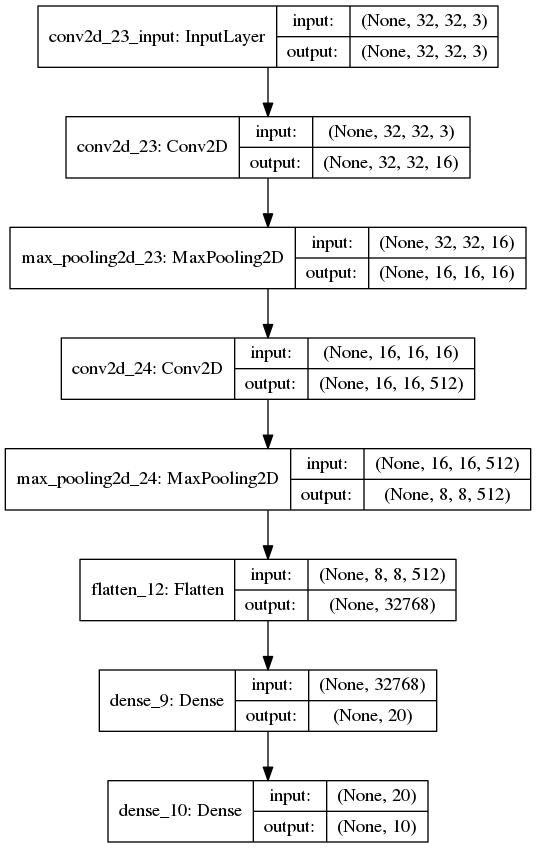

In [31]:
plot_model(model1, to_file='aux.png', show_shapes=True)
Image(filename='aux.png') 

In [10]:
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model1.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])
model1.fit(X_train, Y_train, batch_size=100, epochs=12, verbose=1, validation_data=(X_test, Y_test))

"""
datagen = image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=1280),
                    steps_per_epoch=X_train.shape[0] // 1280,
                    epochs=12,
                    validation_data=(X_test, Y_test))
                    """

Train on 60000 samples, validate on 26032 samples
Epoch 1/12
60000/60000 [==============================] - 388s - loss: 4.3663 - acc: 0.3106 - val_loss: 1.3765 - val_acc: 0.5542
Epoch 2/12
20200/60000 [=========>....................] - ETA: 219s - loss: 1.2639 - acc: 0.6015

KeyboardInterrupt: 

In [ ]:
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(X_test, Y_test)

## D) Modificación del filtro

In [36]:
model = Sequential()
model.add(Conv2D(16, (4, 4), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (6, 6), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model = Sequential()
model.add(Conv2D(16, (2, 2), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (4, 4), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
como varia la mejor

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

## E) Modificación número de filtros en capa Convolucional

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (7, 7), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

## F) Nueva red

quizas mas profunda?? o ccp

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(32, 32,3)))

model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

#validar sobre x_val

## G) Visualizar efecto pesos

In [8]:
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
intermediate_output = intermediate_layer_model.predict(X_train[:100])

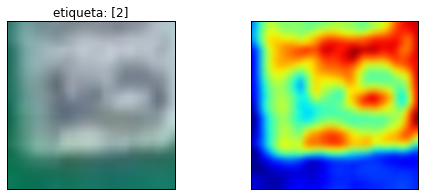

In [18]:
ver_imagen(X_train,y_train,20)

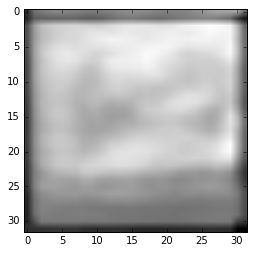

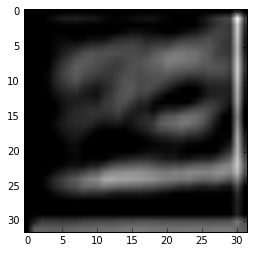

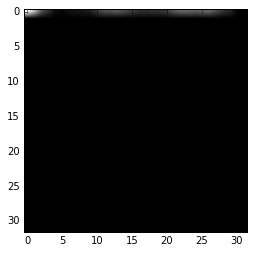

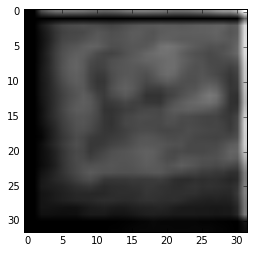

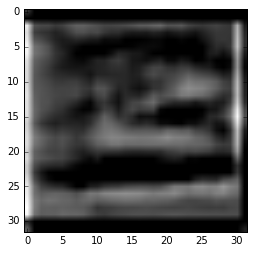

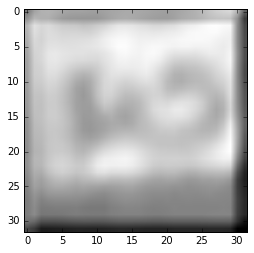

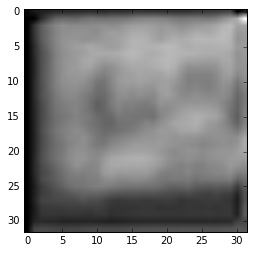

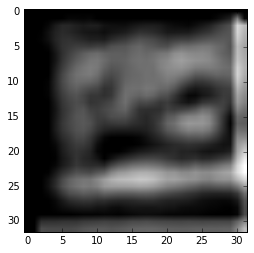

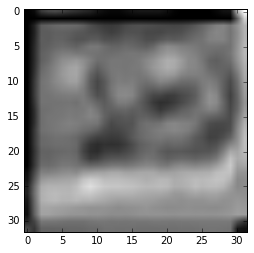

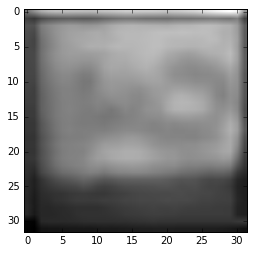

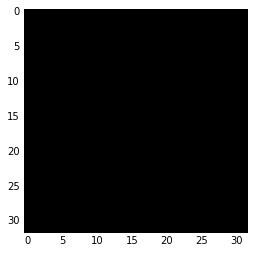

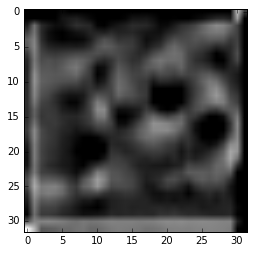

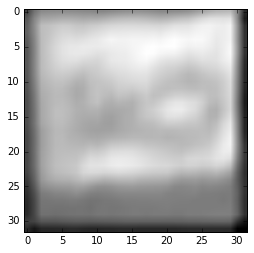

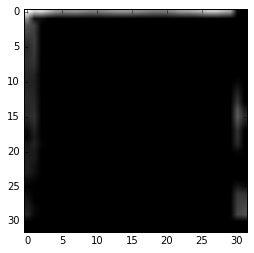

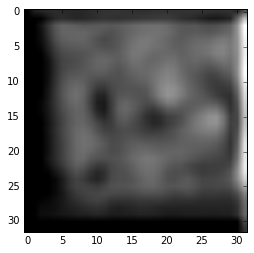

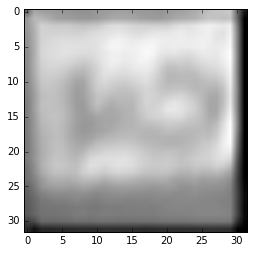

In [23]:
ima = intermediate_output[20]

for i in range(ima.shape[2]):
    plt.imshow(ima[:,:,i],cmap='gray')
    plt.show()

In [58]:
primera_conv = model.layers[0].get_weights()
primera_conv[0].shape

(5, 5, 3, 16)

In [73]:
from matplotlib.pyplot import imshow
inpic = X_train[0]

l = Conv2D(16, (5, 5), padding='same' )
imshow(l.activation(inpic)) #l.activation returns inpic unchanged, so the image is showed again.
plt.show()

TypeError: Invalid dimensions for image data

In [ ]:
model = una buena..



## H) Ejemplos confusión

## I) Utilizar Extra (*Bonus*)